# Tests

In [3]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective # Difference a. We are using ComplexDynamicsProblem
import dimod
import matplotlib.pyplot as plt
import json
import os
import minorminer
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt

In [79]:
def create_instance(precision, number_time_points, simplify = True):
     # We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
    SY = np.array([[0, -1.0j], [1.0j, 0.0]])
    PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

    # The problem object encapsulates all the data so you don't have to pass them around
    problem = ComplexDynamicsProblem(
        hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(number_time_points)),             # With six time points 0,1,2
        num_bits_per_var=precision                # And two bits of precision per variable
    )
    qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian
    num_int = qubo.num_interactions + 1

    # for some reason multiple iterations over the qubo are necessary
    # to remove all 0 couplers
    if simplify:
        while (num_int > qubo.num_interactions):
            num_int = qubo.num_interactions
            for key,value in qubo.quadratic.items():
                if value == 0:
                    qubo.remove_interaction(key[0],key[1])

            
    assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2

    # save instances in the form 
    # systemid_{d}_precision_{d}_timepoints_{d}.json
    # systemid: {1: 0.5 * np.pi * SY}
    file_name = f"../data/instances/pruned/1/precision_{precision}_timepoints_{number_time_points}.json"
    with open(file_name,'w') as f:
        json.dump(qubo.to_serializable(),f)


In [82]:
for precision in range(2,5):
    for timespoints in range(3,6):
        create_instance(precision=precision,number_time_points=timespoints)

In [ ]:
def get_sampleset(precision,timepoints,solver_id="5.4", simplify = False):
    # We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
    SY = np.array([[0, -1.0j], [1.0j, 0.0]])
    PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

    # The problem object encapsulates all the data so you don't have to pass them around
    problem = ComplexDynamicsProblem(
        hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision                # And two bits of precision per variable
    )
    qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian
    num_int = qubo.num_interactions + 1

    if simplify:
        while (num_int > qubo.num_interactions):
            num_int = qubo.num_interactions
            for key,value in qubo.quadratic.items():
                if value == 0:
                    qubo.remove_interaction(key[0],key[1])

            
    assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2



    DW_TOKEN = os.getenv("DW_TOKEN")  # <- Place your token here, or use DW_TOKEN env variable, or configure D-Wave libraries to use config file


    # The graph fo the problem is pretty dense, we use automatic embedding to mitigate the incompatibility with actual machine
    if solver_id == "5.4":
        dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage_system5.4", region="eu-central-1", ))
    elif solver_id == "zephyr": # not working yet
        print("zephyr")
        dw_sampler = EmbeddingComposite(DWaveSampler(solver=dict(id='zephyr')))


    dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)

    dw_result.first.energy
    return dw_result



In [92]:
system = 1
for solver in ["5.4"]:
    print(f"Solver {solver}")
    for i in range(0,5): # number of tests
        print(f"Iteration {i}")
        for timepoints in [3,4,5]:
            for precision in [2]:
                dw_result = get_sampleset(solver_id=solver, precision=precision,timepoints=timepoints,simplify=True)
                file_name = f"../data/results/pruned/{system}/{solver}/precision_{precision}_timepoints_{timepoints}_{i}.json"
                with open(file_name,'w') as f:
                    json.dump(dw_result.to_serializable(),f)

Solver 5.4
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


KeyboardInterrupt: embedding cancelled by keyboard interrupt

# Analyze

In [2]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


In [45]:
def load_data(pruned = True, raw = False):
    if pruned:
        path = '../data/results/pruned/1/'

    else:
        path = '../data/results/notpruned/1/'
    dfs = []
    for topology in ['5.4']:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            s = s.to_pandas_dataframe()

            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [ ]:
dfs_all = load_data(pruned = True)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram

Index(['energy', 'num_occurrences', 'systemid', 'precision', 'timepoints'], dtype='object')

In [ ]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum()
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum()

dfs_grouped_rounded 

/tmp/ipykernel_26561/287085809.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0006 0.003  0.0074 0.0214 0.0408 0.0668 0.0922 0.114  0.1146 0.1234
 0.1046 0.0874 0.0614 0.0534 0.0368 0.0242 0.0174 0.0118 0.0068 0.003
 0.0038 0.0024 0.0006 0.0004 0.0004 0.0008 0.0002 0.0002 0.0002]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum()
/tmp/ipykernel_26561/287085809.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0006 0.003  0.0074 0.0214 0.0408 0.0668 0.0922 0.114  0.1146 0.1234
 0.1046 0.0874 0.0614 0.0534 0.0368 0.0242 0.0174 0.0118 0.0068 0.003
 0.0038 0.0024 0.0006 0.0004 0.0004 0.0008 0.0002 0.0002 0.0002]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped_rou

systemid  precision  timepoints  energy
5.4       2          3           0         0.0038
                                 1         0.0192
                                 2         0.0550
                                 3         0.1166
                                 4         0.1664
                                            ...  
          4          5           68        0.0002
                                 72        0.0002
                                 74        0.0002
                                 87        0.0002
                                 90        0.0002
Name: num_occurrences, Length: 364, dtype: float64

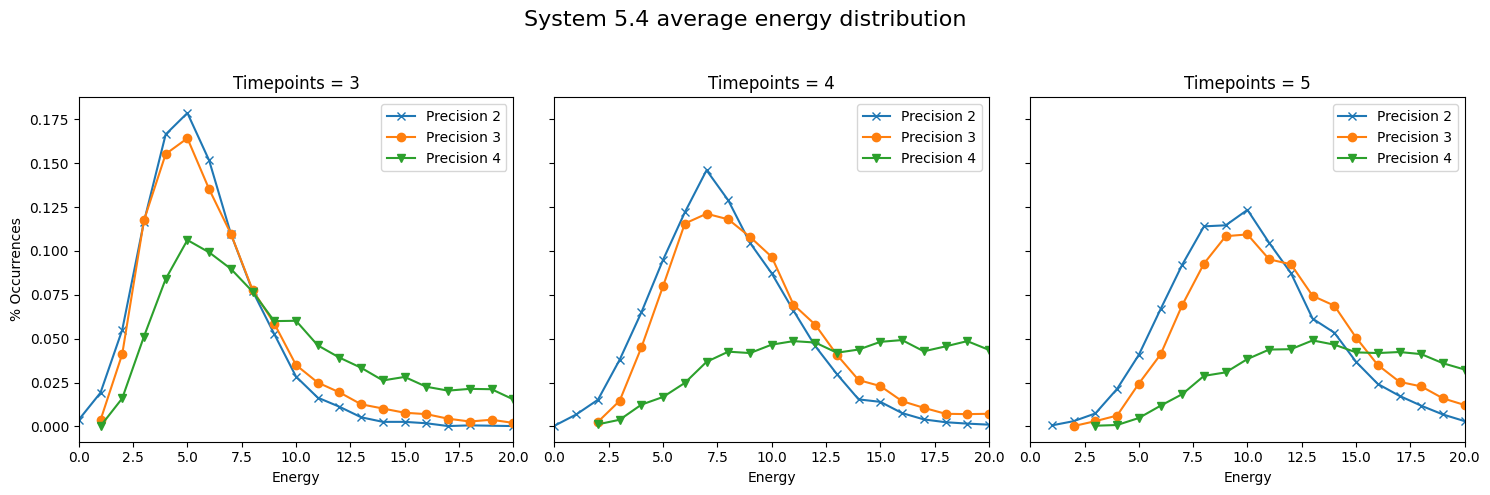

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("System 5.4 average energy distribution", fontsize=16)
markers = ['x','o','v']
for i, timepoints in enumerate(range(3, 6)):
    ax = axes[i]
    for p in [2, 3, 4]:
        df = dfs_grouped_rounded['5.4', p, timepoints].reset_index()
        ax.plot(df['energy'], df['num_occurrences'], label=f"Precision {p}", marker=markers[p-2])

    ax.set_xlabel('Energy')
    ax.set_title(f"Timepoints = {timepoints}")
    ax.set_xlim(0, 20)
    if i == 0:
        ax.set_ylabel('% Occurrences')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../plots/system54_energy_distribution.pdf')
plt.show()

In [102]:
# Let's compute baseline using QuTiP
import qutip as qp

H_qp = 0.5 * np.pi * qp.sigmay()

psi_0 = qp.basis(2, 0)
times = np.linspace(0, 3, 100)
baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]

In [103]:
# Define sigma_z for manual computation of expected values
SZ = np.array([[1, 0], [0, -1]])

# decode_sample returns flat vector, we use reshape to form an 6x2 array of states
#exact_vec = problem.interpret_sample(exact_result.first.sample)

# Difference d.: We use complex conjugation to compute expected values. For this example it shouldn't matter though.
# Then, for the expectation values we take only the real part, because otherwise matplotlib would complain.
#exact_expect = [(state.conj() @ SZ @ state).real for state in exact_vec]

# SA and D-Wave results get the same treatment
#sa_vec = problem.interpret_sample(sa_result.first.sample)
#sa_expect = [(state.conj() @ SZ @ state).real for state in sa_vec]

dw_vec = problem.interpret_sample(dw_result.first.sample)
dw_expect = [(state.conj() @ SZ @ state).real for state in dw_vec]

NameError: name 'problem' is not defined

# Simplification ?

In [61]:
dfs_not_pruned = load_data(pruned=False,precision_range=(2,3))
dfs_not_pruned

,energy,num_occurrences,systemid,precision,timepoints
0,1.0,1,5.4,2,3
1,1.0,1,5.4,2,3
2,1.0,1,5.4,2,3
3,2.0,1,5.4,2,3
4,2.0,1,5.4,2,3
...,...,...,...,...,...
995,20.0,1,5.4,2,5
996,29.0,1,5.4,2,5
997,22.0,1,5.4,2,5
998,52.0,1,5.4,2,5


In [64]:
dfs_not_pruned['energy'] = round(dfs_not_pruned['energy'] +0.499) # for displaying in a histogram
dfs_not_pruned = dfs_not_pruned.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_not_pruned

systemid  precision  timepoints  energy
5.4       2          3           0.0         2
                                 1.0        26
                                 2.0        86
                                 3.0       221
                                 4.0       344
                                          ... 
                     5           54.0        4
                                 57.0        1
                                 58.0        1
                                 60.0        1
                                 64.0        1
Name: num_occurrences, Length: 136, dtype: int64

(0.0, 10.0)

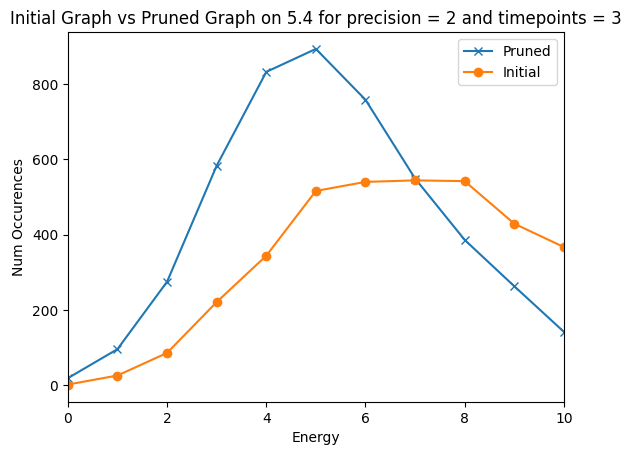

In [75]:
#plt.plot(dfs_not_pruned['energy'],dfs_not_pruned['num_occurrences'],label="Full graph",marker='o')
plt.plot(dfs_grouped['5.4',2,3],label="Pruned",marker='x')
plt.plot(dfs_not_pruned['5.4',2,3],label="Initial",marker='o')

plt.xlabel('Energy')
plt.title("Initial Graph vs Pruned Graph on 5.4 for precision = 2 and timepoints = 3")
plt.ylabel('Num Occurences')
plt.legend()

plt.xlim(0,10)

-more qubits
-pt symmetric eq 12 paper
- include specific machine

# Interpret results

In [88]:
dfs_data_raw = load_data(raw=True)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
tp_pairs

[(2, 3), (2, 4), (2, 5), (3, 3), (3, 4), (3, 5), (4, 3), (4, 4), (4, 5)]

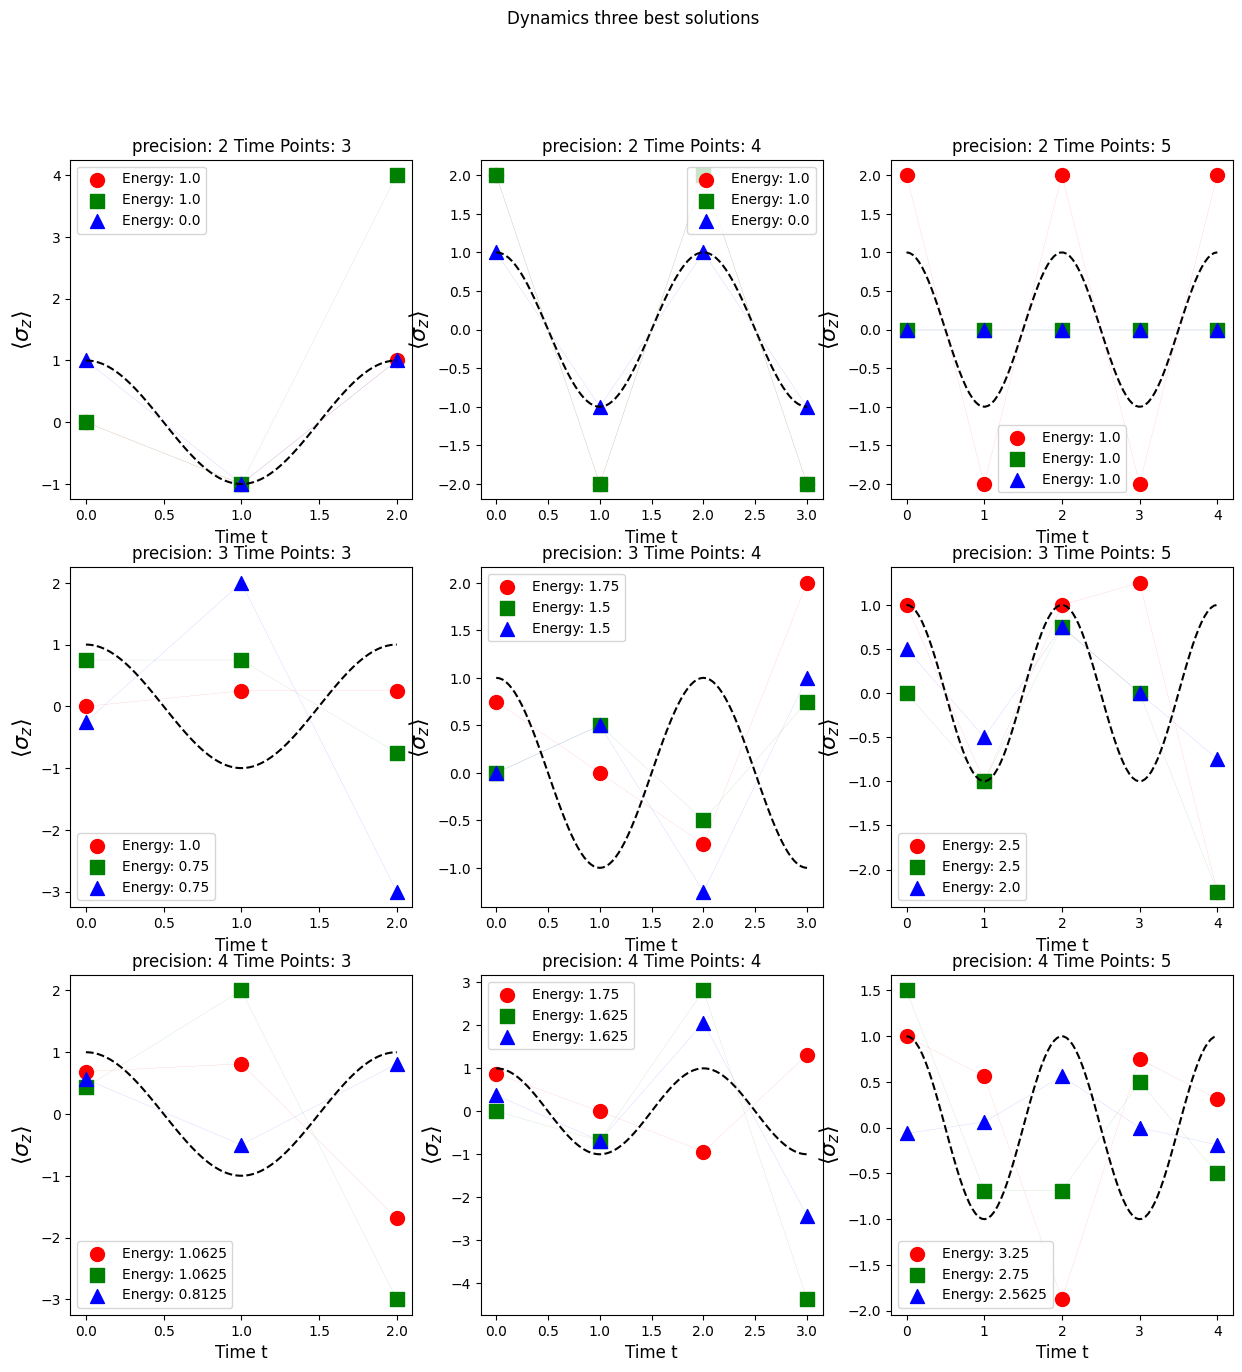

In [97]:
import qutip as qp

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

for i, (precision,timepoints) in enumerate(tp_pairs):
    #baseline 

    H_qp = 0.5 * np.pi * qp.sigmay()
    psi_0 = qp.basis(2, 0)
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]

    ax = axes[i]

    ax.plot(times, baseline, "k--")

    problem = ComplexDynamicsProblem(
        hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(3)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)
        SZ = np.array([[1, 0], [0, -1]])

        expect = [(state.conj() @ SZ @ state).real for state in vec]
        ax.scatter(problem.times, expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"Energy: {energies[j]}", alpha=1.0, s=100)
        ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
fig.suptitle("Dynamics three best solutions")
plt.show()



In [34]:
sol_dict = dfs_data_raw.iloc[0,:].dropna().to_dict()
sol_dict = {key:int(value) for key,value in sol_dict.items()}

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

prec = 2
timepoints = 4
problem = ComplexDynamicsProblem(
    hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
    initial_state = PSI0,              # Starting at initial state |0>,
    times=tuple(range(timepoints)),             # With six time points 0,1,2
    num_bits_per_var=prec               # And two bits of precision per variable
)
print(sol_dict)
vec =problem.interpret_sample(sol_dict)

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 1, 24: 0, 25: 1, 26: 0, 27: 1, 28: 0, 29: 0, 30: 0, 31: 1}


In [ ]:
SZ = np.array([[1, 0], [0, -1]])

expect = [(state.conj() @ SZ @ state).real for state in vec]

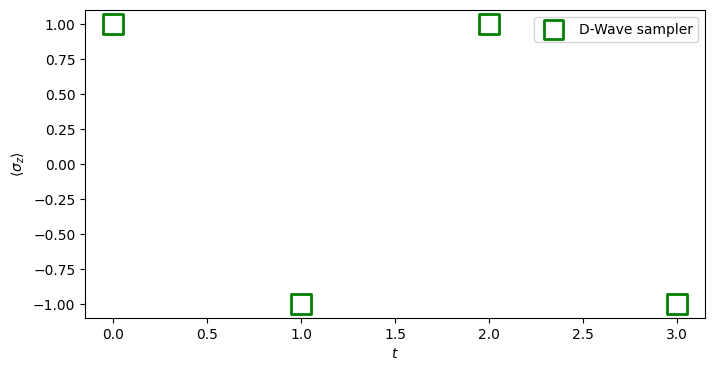

In [36]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize=(8, 4))

#axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

#axis.scatter(problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
#axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
axis.scatter(problem.times, expect, marker="s", lw=2, s=200, edgecolors="g", facecolors="none", label="D-Wave sampler")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()